<a href="https://colab.research.google.com/github/KayvanShah1/usc-dsci-552-lab-assignments-hw/blob/main/assignment-5/Kayvan_Shah_Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing & Importing required Modules & Libraries

In [1]:
!pip install ipython-autotime
%matplotlib inline
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.8 MB/s eta 0:00:00
time: 598 µs (started: 2023-04-02 22:24:23 +00:00)


In [44]:
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf

time: 986 µs (started: 2023-04-02 22:56:29 +00:00)


# TPU Configuration

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.105.90.66:8470


REPLICAS:  8
time: 16.1 s (started: 2023-04-02 22:24:29 +00:00)


# Data Preparation

In [4]:
# Load data
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()

# Train, Validation & Test Split
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

# Scale the Dataset
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

4422102/4422102 [==============================] - 0s 0us/step
time: 4.85 s (started: 2023-04-02 22:24:45 +00:00)


# Exploratory Data Analysis

In [5]:
print("Train size:", X_train.shape)
print("Validation size:", X_valid.shape)
print("Test size:", X_test.shape)

Train size: (55000, 28, 28)
Validation size: (5000, 28, 28)
Test size: (10000, 28, 28)
time: 7.61 ms (started: 2023-04-02 22:24:50 +00:00)


In [6]:
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 
    'Dress', 'Coat','Sandal', 'Shirt', 
    'Sneaker', 'Bag', 'Ankle boot'
]

time: 668 µs (started: 2023-04-02 22:24:50 +00:00)


In [7]:
def plot_mnist_data(num_row = 3, num_col = 5):
    # get a segment of the dataset
    num = num_row*num_col
    images = X_train[:num]
    labels = y_train[:num]

    # plot images
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.25*num_col,1.25*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i])
        ax.set_title('Label: {}'.format(class_names[labels[i]]), fontsize=8)
    plt.tight_layout()
    plt.show()

time: 1.09 ms (started: 2023-04-02 22:24:50 +00:00)


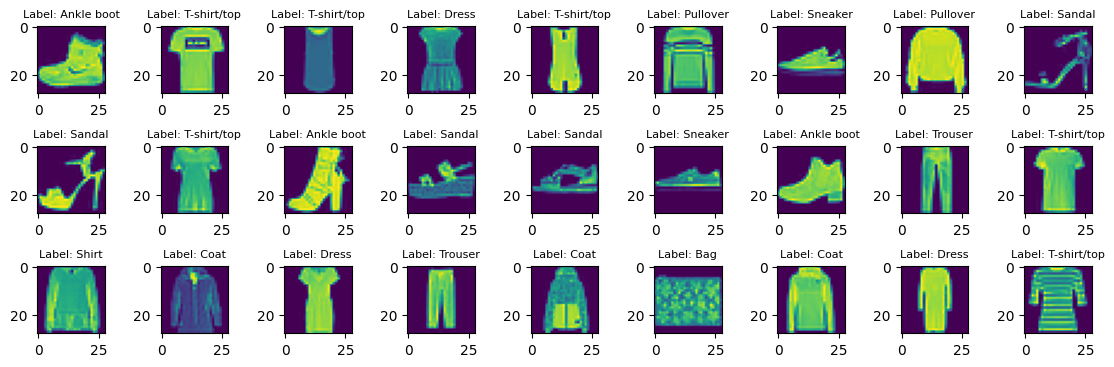

time: 11.5 s (started: 2023-04-02 22:24:50 +00:00)


In [8]:
plot_mnist_data(num_row = 3, num_col = 9)

# Converting to Tensorflow dataset

In [10]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

time: 874 µs (started: 2023-04-02 22:25:06 +00:00)


In [11]:
train = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid = (
    tf.data.Dataset
    .from_tensor_slices((X_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
#     .repeat()
#     .shuffle(256)
    .prefetch(AUTO)
)

test = (
    tf.data.Dataset
    .from_tensor_slices((X_test,y_test))
    .batch(BATCH_SIZE)
    .cache()
#     .shuffle(256)
    .prefetch(AUTO)
)

time: 5.85 s (started: 2023-04-02 22:25:06 +00:00)


# Train Models

## Part One

### Fashion MNIST Neural Network
Follow the instructions in Chapter 10 of Aurelien (Hands-on Machine Learning) to create a fourlayer neural network (1 Flatten Layer and 3 Dense Layers) and train it on the Fashion MNIST
dataset.

What to turn in:
- The CPU Times and Wall Times returned by fit() from the training process
- Generate loss and accuracy versus epoch plots (see Figure 10-11)
- The accuracy, precision and recall on the test test
- The precision and recall values by class_id on the test test. There are 10 classes.

### Build Model

In [12]:
def build_basic_model():
    tf.random.set_seed(42)
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(300, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])
    
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer="sgd",
        metrics=["accuracy"]
    )
    return model

time: 947 µs (started: 2023-04-02 22:25:18 +00:00)


In [31]:
# Clear backend sessions to reset name counters
tf.keras.backend.clear_session()

with strategy.scope():
    model = build_basic_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
time: 306 ms (started: 2023-04-02 22:43:49 +00:00)


In [32]:
pprint(model.layers)

hidden1 = model.layers[1]
print(hidden1.name)

print(model.get_layer('dense') is hidden1)

dense
True
time: 1.26 ms (started: 2023-04-02 22:43:52 +00:00)


In [33]:
# Getting weights and baises of the model 
weights, biases = hidden1.get_weights()
print("============= Weights =============")
print(weights)
print(weights.shape)
print("\n============= Biases =============")
print(biases)
print(biases.shape)

============= Weights =============
[[-0.01322708  0.05910218  0.01273601 ... -0.06124732  0.03543942
  -0.0255857 ]
 [-0.05912587 -0.02679883  0.04556003 ...  0.0541731   0.02574156
   0.06977189]
 [-0.04345481 -0.02695898  0.04277804 ... -0.05965387 -0.03771272
   0.06739455]
 ...
 [ 0.02541505  0.0302989   0.0556363  ... -0.02179766  0.05713511
  -0.04797313]
 [ 0.06926464  0.03336934 -0.00751532 ... -0.0622384   0.02115922
   0.01984314]
 [ 0.07377228 -0.00277755 -0.05615984 ... -0.04773317  0.02137236
  -0.05271249]]
(784, 300)

============= Biases =============
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

### Train Model

In [34]:
EPOCHS = 30

n_steps = X_train.shape[0] // BATCH_SIZE

time: 862 µs (started: 2023-04-02 22:43:56 +00:00)


In [35]:
%%time
train_history = model.fit(
    train,
    steps_per_epoch=n_steps//2,
    validation_data=valid,
    epochs=EPOCHS
)

Epoch 1/30
214/214 [==============================] - 7s 26ms/step - loss: 1.3247 - accuracy: 0.6115 - val_loss: 0.8732 - val_accuracy: 0.7300
Epoch 2/30
214/214 [==============================] - 6s 26ms/step - loss: 0.7825 - accuracy: 0.7457 - val_loss: 0.6975 - val_accuracy: 0.7644
Epoch 3/30
214/214 [==============================] - 5s 22ms/step - loss: 0.6672 - accuracy: 0.7812 - val_loss: 0.6151 - val_accuracy: 0.7952
Epoch 4/30
214/214 [==============================] - 5s 22ms/step - loss: 0.6057 - accuracy: 0.8024 - val_loss: 0.5683 - val_accuracy: 0.8114
Epoch 5/30
214/214 [==============================] - 5s 24ms/step - loss: 0.5700 - accuracy: 0.8097 - val_loss: 0.5398 - val_accuracy: 0.8216
Epoch 6/30
214/214 [==============================] - 5s 25ms/step - loss: 0.5384 - accuracy: 0.8204 - val_loss: 0.5437 - val_accuracy: 0.8096
Epoch 7/30
214/214 [==============================] - 5s 23ms/step - loss: 0.5222 - accuracy: 0.8221 - val_loss: 0.5039 - val_accuracy: 0.8282

### Evaluate Model

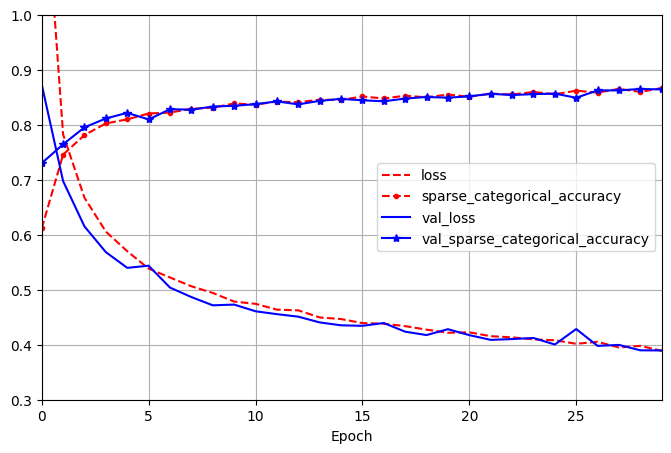

time: 435 ms (started: 2023-04-02 22:51:32 +00:00)


In [41]:
pd.DataFrame(train_history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0.3, 1], 
    grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"],
)
plt.legend(labels=["loss", "sparse_categorical_accuracy", "val_loss", "val_sparse_categorical_accuracy"])
plt.show()

In [42]:
model.evaluate(test)

79/79 [==============================] - 4s 22ms/step - loss: 0.4253 - accuracy: 0.8480


[0.4252837300300598, 0.8479999899864197]

time: 4.17 s (started: 2023-04-02 22:52:01 +00:00)


In [43]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 2s 2s/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.  , 0.15, 0.  , 0.68],
       [0.  , 0.  , 0.88, 0.  , 0.01, 0.  , 0.11, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

time: 1.88 s (started: 2023-04-02 22:55:21 +00:00)


In [50]:
print("Predicted classes")
y_pred = y_proba.argmax(axis=-1)
print(y_pred)
print(np.array(class_names)[y_pred])

print("\nOriginal classes")
y_new = y_test[:3]
print(y_new)
print(np.array(class_names)[y_new])

Predicted classes
[9 2 1]
['Ankle boot' 'Pullover' 'Trouser']

Original classes
[9 2 1]
['Ankle boot' 'Pullover' 'Trouser']
time: 27 ms (started: 2023-04-02 22:59:26 +00:00)


## Part 2

### Fashion MNIST Convolutional Neural Network
Repeat part problem 2, but this time create a convolution neural network using the Fashion
MNIST network in Chapter 14 of Aurelien.

### Build Model

In [55]:
from functools import partial

def build_basic_model():
    DefaultConv2D = partial(
        tf.keras.layers.Conv2D, 
        kernel_size=3, 
        padding="same",
        activation="relu", 
        kernel_initializer="he_normal"
    )
    
    model = tf.keras.Sequential([
        DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=128, activation="relu", kernel_initializer="he_normal"
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
            units=64, activation="relu", kernel_initializer="he_normal"
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=10, activation="softmax")
    ])
    
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer="sgd",
        metrics=["accuracy"]
    )
    return model

time: 10.1 ms (started: 2023-04-02 23:08:14 +00:00)


In [56]:
# Clear backend sessions to reset name counters
tf.keras.backend.clear_session()

with strategy.scope():
    model = build_basic_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         2

### Train Model

In [61]:
EPOCHS = 10

n_steps = X_train.shape[0] // BATCH_SIZE

time: 793 µs (started: 2023-04-02 23:11:35 +00:00)


In [62]:
%%time
train_history = model.fit(
    train,
    steps_per_epoch=n_steps,
    validation_data=valid,
    epochs=EPOCHS
)

Epoch 1/10
429/429 [==============================] - 9s 21ms/step - loss: 0.7294 - accuracy: 0.7418 - val_loss: 0.4614 - val_accuracy: 0.8300
Epoch 2/10
429/429 [==============================] - 11s 25ms/step - loss: 0.6467 - accuracy: 0.7754 - val_loss: 0.4369 - val_accuracy: 0.8452
Epoch 3/10
429/429 [==============================] - 10s 22ms/step - loss: 0.5966 - accuracy: 0.7945 - val_loss: 0.4095 - val_accuracy: 0.8500
Epoch 4/10
429/429 [==============================] - 9s 21ms/step - loss: 0.5603 - accuracy: 0.8058 - val_loss: 0.3861 - val_accuracy: 0.8602
Epoch 5/10
429/429 [==============================] - 9s 21ms/step - loss: 0.5245 - accuracy: 0.8200 - val_loss: 0.3742 - val_accuracy: 0.8662
Epoch 6/10
429/429 [==============================] - 9s 22ms/step - loss: 0.5006 - accuracy: 0.8291 - val_loss: 0.3632 - val_accuracy: 0.8708
Epoch 7/10
429/429 [==============================] - 9s 21ms/step - loss: 0.4782 - accuracy: 0.8386 - val_loss: 0.3522 - val_accuracy: 0.87

### Evaluate Model

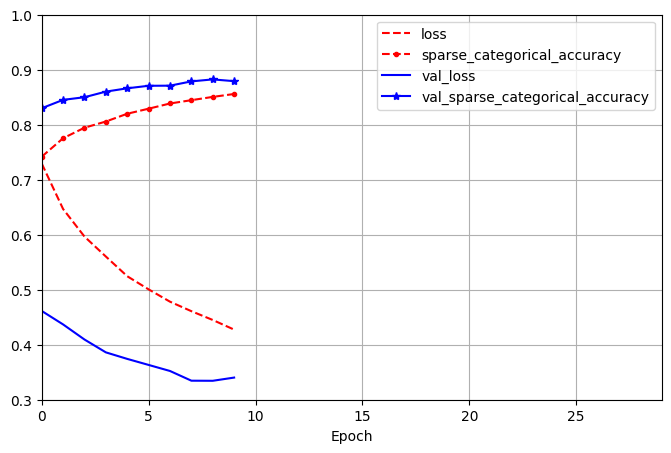

time: 289 ms (started: 2023-04-02 23:13:17 +00:00)


In [63]:
pd.DataFrame(train_history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0.3, 1], 
    grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"],
)
plt.legend(labels=["loss", "sparse_categorical_accuracy", "val_loss", "val_sparse_categorical_accuracy"])
plt.show()

In [64]:
model.evaluate(test)

79/79 [==============================] - 3s 17ms/step - loss: 0.3546 - accuracy: 0.8735


[0.3546266257762909, 0.8734999895095825]

time: 2.8 s (started: 2023-04-02 23:13:21 +00:00)


In [65]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 3s 3s/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.97],
       [0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

time: 3.15 s (started: 2023-04-02 23:13:25 +00:00)


In [66]:
print("Predicted classes")
y_pred = y_proba.argmax(axis=-1)
print(y_pred)
print(np.array(class_names)[y_pred])

print("\nOriginal classes")
y_new = y_test[:3]
print(y_new)
print(np.array(class_names)[y_new])

Predicted classes
[9 2 1]
['Ankle boot' 'Pullover' 'Trouser']

Original classes
[9 2 1]
['Ankle boot' 'Pullover' 'Trouser']
time: 1.9 ms (started: 2023-04-02 23:13:30 +00:00)


# THE END